---
title: SWOT and ICESat-2 corrections and comparison
authors:
  - name: Zachary Katz
    affiliation: Colorado School of Mines
  - name: Tasha Snow
    affiliation: University of Maryland, NASA Goddard Space Flight Center
license: MIT

---

In [1]:
%pip install -q pyTMD
%pip install -q icesat2_toolkit
%pip install -q cmap
%pip install -q PyAstronomy
# %pip install -q git+https://github.com/SlideRuleEarth/h5coro.git@v1.0

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [2]:
cd ../src

/home/jovyan/SWOT_ESR_UMD_Mines_collab/Scripts/PYTHON/src


# Map SWOT LR and HR data coverage over Antarctica

In [1]:
"""
Zachary Katz
zachary_katz@mines.edu

Figure 1 of SWOT cryosphere ice shelves paper.

Requires data files and correct paths, as set in this cell under the section
'### User-Defined Paramaters ##'

#Scripps Antarctic Grounding Line:
[dataset page] https://doi.pangaea.de/10.1594/PANGAEA.819147)
[direct download](https://doi.pangaea.de/10013/epic.42133.d001)
scripps_antarctica_polygons_v1.shp

*MEaSUREs Phase-Based Antarctica Ice Velocity Map, v2 (Requires NASA Earthdata Login):
[dataset page] https://nsidc.org/data/nsidc-0484/versions/2
[direct download] https://data.nsidc.earthdatacloud.nasa.gov/nsidc-cumulus-prod-protected/MEASURES/NSIDC-0484/2/1996/01/01/antarctica_ice_velocity_450m_v2.nc
antarctica_ice_velocity_450m_v2.nc

*MODIS Mosaic of Antarctica 2009, 750 m, hp1, v1.1 (Must unzip after download):
Version 2 dataset page currently downloads v1.1?
[dataset page] https://nsidc.org/data/nsidc-0593/versions/2
[direct download] https://daacdata.apps.nsidc.org/pub/DATASETS/nsidc0593_moa2009_v02/geotiff/moa750_2009_hp1_v02.0.tif.gz
moa750_2009_hp1_v1.1.tif

SWOT Mask High Resolution
[dataset page] https://podaac.jpl.nasa.gov/SWOT-events/SWOT_events.html
[direct download] https://podaac.jpl.nasa.gov/SWOT-events/swot_science_hr_Nov2024-v09-seasonal_perPass.kml
swot_science_hr_Nov2024-v09-seasonal_perPass.kml

SWOT Mask Low Resolution
[dataset page] https://www.aviso.altimetry.fr/en/missions/current-missions/swot/orbit.html
[direct download] https://www.aviso.altimetry.fr/fileadmin/documents/missions/Swot/swot_science_orbit_sept2015-v2_10s.kmz
swot_science_orbit_sept2015-v2_10s.kml



v0.1 17 May 2025
 - Draft figre showing SWOT LR, HR, and boxes where figures 2-4 are located
v0.2 07 July 2025
 - Code cleanup and renaming in prep for sharing with coauthors
"""

%matplotlib widget

# Imports
import os
import pandas as pd
import shapefile

import matplotlib.pyplot as plt
import cartopy.crs as ccrs

import geopandas as gpd
import fiona

# For downloading datasets
import requests
import zipfile
import io
from io import BytesIO
from pathlib import Path
import earthaccess
import xarray as xr
import gzip
import rasterio
import tempfile
import warnings
from zipfile import ZipFile
import tempfile

#############################
## **User-Defined Parameters ##
basepath = Path('/home/jovyan/SWOT_ESR_UMD_Mines_collab')
datapath = Path('/home/jovyan/shared-public/SWOT/data')
gl_path = datapath / "Antarctica_masks/scripps_antarctica_polygons_v1.shp"  # Path to Grounding Line
# vel_path = datapath / "antarctica_ice_velocity_450m_v2.nc"  # Path to velocity field
# moa_path = datapath / "moa750_2009_hp1_v1.1.tif"  # Path to MOA
# kml_hr_path = datapath / "swot_science_hr_Nov2024-v09-seasonal_perPass.kml"
# kml_lr_path = datapath / "swot_science_orbit_sept2015-v2_10s.kml"
kml_hr_path = datapath / "hr_Nov2024_below60S.kml"
# Figure extents to show as boxes on Figure 1, in PS71
# Change based on the actual extents shown in future figures
bach = [-1920000, 480000, -1740000, 680000]
amery = [1500000, 590000, 2480000, 850000]
thwaites = [-1647000, -535900, -1517000, -304300]
ameryInset = [
    1798298.7074357467,
    758054.629860756,
    1892703.2831982453,
    716098.1128340638,
]
larsenC = [-2450000, 950000, -1900000, 1400000]
## User-Defined Parameters ##
#############################

# Suppress specific RuntimeWarning from pyogrio/GDAL
warnings.filterwarnings("ignore", message=".*ERROR parsing kml Style: No id.*", category=RuntimeWarning)
os.environ["CPL_DEBUG"] = "OFF"

In [2]:
# Download Antarctica_masks/scripps_antarctica_polygons_v1.shp if doesn't yet exist
datapath.mkdir(parents=True, exist_ok=True)

if not gl_path.exists():
    # Download URL
    url = "https://doi.pangaea.de/10013/epic.42133.d001"
    
    # Download the ZIP file
    response = requests.get(url)
    response.raise_for_status()  # raises error if download fails
    
    # Extract ZIP contents to gl_path
    with zipfile.ZipFile(io.BytesIO(response.content)) as z:
        z.extractall(datapath)
    
    print(f"Shapefiles extracted to: {datapath}")

In [3]:
# Authenticate for accessing NASA data
auth = earthaccess.login(strategy="netrc")

# If we are not authenticated
if not auth.authenticated:
    # Ask for credentials and persist them in a .netrc file ** never push the netrc to GitHub
    auth.login(strategy="interactive", persist=True)

In [4]:
# Open antarctica_ice_velocity_450m_v2.nc into memory
results = earthaccess.search_data(
    short_name="NSIDC-0484",
    cloud_hosted=True,
    temporal=("1996-01-01", "1996-01-02"),
    count=1
)

opened = earthaccess.open(results)
vel = xr.open_dataset(opened[0])

QUEUEING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]

In [5]:
# Open moa750_2009_hp1_v02.0.tif into memory

# URL of the protected gzip file
url = "https://daacdata.apps.nsidc.org/pub/DATASETS/nsidc0593_moa2009_v02/geotiff/moa750_2009_hp1_v02.0.tif.gz"

# Use Earthdata login stored in ~/.netrc (standard for requests)
session = requests.Session()
session.auth = requests.utils.get_netrc_auth(url)

# Add user-agent to mimic a real browser
headers = {"User-Agent": "NASA Earthdata Python client"}

# Download and check for success
response = session.get(url, headers=headers)
response.raise_for_status()

# Confirm content-type is not HTML (debug print)
if b"<html" in response.content[:100].lower():
    raise RuntimeError("Download returned HTML (login failed or wrong credentials?)")

# Decompress the GZip in memory
with gzip.GzipFile(fileobj=BytesIO(response.content)) as gz:
    tif_bytes = BytesIO(gz.read())

# Read with Rasterio from memory
with rasterio.MemoryFile(tif_bytes) as memfile:
    with memfile.open() as moa:
        print("Bounds:", moa.bounds)
        print("CRS:", moa.crs)

Bounds: BoundingBox(left=-3174450.0, bottom=-2816675.0, right=2867550.0, top=2406325.0)
CRS: PROJCS["unnamed",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257024882273,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],PROJECTION["Polar_Stereographic"],PARAMETER["latitude_of_origin",-71],PARAMETER["central_meridian",0],PARAMETER["false_easting",0],PARAMETER["false_northing",0],UNIT["metre",1],AXIS["Easting",NORTH],AXIS["Northing",NORTH]]


In [6]:
# Open and trim HR coverage (swot_science_hr_Nov2024-v09-seasonal_perPass.kml) to south of 60S if not already done
# Wall time: 23min 13s

# Segment kml to below 60S to reduce
if not os.path.exists(kml_hr_path):
    
    # Download the KML
    url = "https://podaac.jpl.nasa.gov/SWOT-events/swot_science_hr_Nov2024-v09-seasonal_perPass.kml"
    response = requests.get(url)
    response.raise_for_status()
    
    # Save to a temporary file
    with tempfile.NamedTemporaryFile(suffix=".kml", delete=False) as tmp:
        tmp.write(response.content)
        kml_path = tmp.name
    
    # Try to read all layers, with error handling
    layers = fiona.listlayers(kml_path)
    gdfs = {}
    
    for layer in layers:
        try:
            gdf_layer = gpd.read_file(kml_path, driver="KML", layer=layer)
            if not gdf_layer.empty:
                gdfs[layer] = gdf_layer
        except Exception as e:
            print(f"Failed to load layer '{layer}': {e}")
    
    # Remove tmp file
    os.remove(kml_path)
    
    # Combine loaded layers
    if gdfs:
        gdf = gpd.GeoDataFrame(pd.concat(gdfs.values(), ignore_index=True))
        gdf = gdf[gdf.geometry.bounds["miny"] < -60]
        print(f"Loaded {len(gdf)} features")
    else:
        raise RuntimeError("No valid layers could be loaded.")
    
    gdf.to_file(kml_hr_path, driver="KML")

In [7]:
# Open trimmed 60S HR orbit file
layers = fiona.listlayers(kml_hr_path)
gdfs = {
    layer: gpd.read_file(kml_hr_path, driver="KML", layer=layer) for layer in layers[:]
}
gdf = gpd.GeoDataFrame(pd.concat(gdfs.values(), ignore_index=True))

ps71_projection = ccrs.Stereographic(
    central_latitude=-90, central_longitude=0, true_scale_latitude=-71
)
gdf_proj = gdf.to_crs(ps71_projection.proj4_init)
gdf_proj_hr = gdf_proj[~gdf_proj["Name"].str.contains("Nadir")]

In [ ]:
# Read in LR coverage (swot_science_orbit_sept2015-v2_10s.kmz) - Wall time: 5min 12s, downloading and saving makes this faster (no temp)

# Download and extract KMZ
url = "https://www.aviso.altimetry.fr/fileadmin/documents/missions/Swot/swot_science_orbit_sept2015-v2_10s.kmz"
r = requests.get(url)
r.raise_for_status()

# Extract KML to temp file
with tempfile.NamedTemporaryFile(suffix=".kml", delete=False) as tmp_kml:
    with ZipFile(BytesIO(r.content)) as kmz:
        # Extract the first KML inside the KMZ
        kml_name = next(name for name in kmz.namelist() if name.lower().endswith(".kml"))
        kml_data = kmz.read(kml_name)
        tmp_kml.write(kml_data)
        kml_path = tmp_kml.name  # file path to extracted KML

# List layers and read them all
layers = fiona.listlayers(kml_path)
gdfs = {}

for layer in layers:
    try:
        gdf = gpd.read_file(kml_path, driver="KML", layer=layer)
        if not gdf.empty:
            gdfs[layer] = gdf
    except Exception as e:
        print(f"Skipped layer '{layer}' due to error: {e}")

# Combine all non-empty layers
if not gdfs:
    raise RuntimeError("No valid layers were loaded.")
gdf = gpd.GeoDataFrame(pd.concat(gdfs.values(), ignore_index=True))

# Remove tmp file
os.remove(kml_path)

print(f"Loaded {len(gdf)} features from {len(gdfs)} layers.")


ps71_projection = ccrs.Stereographic(
    central_latitude=-90, central_longitude=0, true_scale_latitude=-71
)
gdf_proj = gdf.to_crs(ps71_projection.proj4_init)
gdf_proj_lr = gdf_proj[~gdf_proj["Name"].str.contains("Nadir")]

In [ ]:
# Plot Figure 1
fig, ax = plt.subplots(subplot_kw={"projection": ps71_projection}, figsize=(10, 10))

ice_shelf_polygons = []
grounded_polygons = []

sf = shapefile.Reader(gl_path)
fields = sf.fields[1:]  # Skip deletion flag
field_names = [field[0] for field in fields]

records = sf.records()
shapes = sf.shapes()

for record, shape in zip(records, shapes):
    classification = record[field_names.index("Id_text")]
    points = shape.points
    parts = list(shape.parts)
    parts.append(len(points))  # Append the end index of the last part
    for i in range(len(parts) - 1):
        part = points[parts[i] : parts[i + 1]]
        if (
            classification == "Isolated island"
            or classification == "Ice rise or connected island"
            or classification == "Grounded ice or land"
        ):
            ax.fill(*zip(*part), color="darkgray", linewidth=0.5, zorder=2)
        elif classification == "Ice shelf":
            ax.fill(*zip(*part), color="lightgray", linewidth=0.5, zorder=2)
        else:
            print(f"Unknown classification: {classification}")

gdf_proj_lr.plot(
    ax=ax,
    transform=ps71_projection,
    edgecolor="red",
    facecolor="red",
    alpha=0.1,
    linewidth=0.1,
    zorder=3,
)
gdf_proj_hr.plot(
    ax=ax,
    transform=ps71_projection,
    edgecolor="blue",
    facecolor="blue",
    alpha=0.4,
    linewidth=0.1,
    zorder=3,
)
ax.set_xlim(-3000000, 3000000)
ax.set_ylim(-3000000, 3000000)

# Add boxes for figures 2-4
amery_rect = plt.Rectangle(
    (
        amery[0],
        amery[1],
    ),
    amery[2] - amery[0],
    amery[3] - amery[1],
    zorder=4,
    linewidth=2,
    edgecolor="white",
    facecolor="none",
)
ax.add_patch(amery_rect)
bach_rect = plt.Rectangle(
    (
        bach[0],
        bach[1],
    ),
    bach[2] - bach[0],
    bach[3] - bach[1],
    zorder=4,
    linewidth=2,
    edgecolor="white",
    facecolor="none",
)
ax.add_patch(bach_rect)
thwaites_rect = plt.Rectangle(
    (
        thwaites[0],
        thwaites[1],
    ),
    thwaites[2] - thwaites[0],
    thwaites[3] - thwaites[1],
    zorder=4,
    linewidth=2,
    edgecolor="white",
    facecolor="none",
)
ax.add_patch(thwaites_rect)
ameryInset_rect = plt.Rectangle(
    (
        ameryInset[0],
        ameryInset[1],
    ),
    ameryInset[2] - ameryInset[0],
    ameryInset[3] - ameryInset[1],
    zorder=4,
    linewidth=2,
    edgecolor="white",
    facecolor="none",
)
ax.add_patch(ameryInset_rect)

ax.text(
    amery[0] + 10000,
    amery[3] - 10000,
    "4",
    fontsize=12,
    weight="bold",
    ha="left",
    va="top",
    color="white",
)

ax.text(
    bach[0] + 10000,
    bach[3] - 10000,
    "2",
    fontsize=12,
    weight="bold",
    ha="left",
    va="top",
    color="white",
)

ax.text(
    ameryInset[0] + 10000,
    ameryInset[3] - 10000,
    "3",
    fontsize=12,
    weight="bold",
    ha="left",
    va="top",
    color="white",
)

# fig.savefig("../figures/Figure1_tms.png", dpi=500, bbox_inches="tight")

## Correct SWOT and IS2 data

In [ ]:
"""
Zachary Katz
zachary_katz@mines.eud

Figure 2 of SWOT cryosphere ice shelves paper.

As for Figure 1, Requires data files and correct paths, as set in this cell 
under the section '### User-Defined Paramaters ##'
See the first cell of Figure1.ipynb for locations to download these files.

In addition, we need the CATS2008_v2023 tide model from https://doi.org/10.15784/601772.
Place CATS2008_v2023.nc in a folder called CATS2008_v2023 in 'tide_dir
CATS2008_v2023.nc


v0.1 17 May 2025
 - Draft figure showing SWOT vs ICESat-2 at Bach
v0.2 07 July 2025
 - Code cleanup and renaming in prep for sharing with coauthors
"""

# Imports and Extensions
%matplotlib widget

import util.coordinate_transforms as transform
import tides.Tides as Tides

import datetime
import numpy as np
import xarray as xr
import shapefile
from shapely.plotting import plot_line
from shapely.geometry import LineString
import h5py
import icesat2_toolkit
from cmap import Colormap
import rasterio
from PyAstronomy import pyasl
from pathlib import Path
import earthaccess
from scipy.interpolate import RegularGridInterpolator

import matplotlib as mpl
import matplotlib.ticker as ticker
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib.lines import Line2D
from matplotlib.patches import Patch
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from mpl_toolkits.axes_grid1.anchored_artists import AnchoredSizeBar
import cartopy.crs as ccrs

from pathlib import Path
import requests
import gzip
import s3fs
import numpy as np
import re

#############################
## User-Defined Parameters ##
basepath = Path('/home/jovyan/SWOT_ESR_UMD_Mines_collab')
datapath = Path('/home/jovyan/shared-public/SWOT/data')
gl_path = datapath / "Antarctica_masks/scripps_antarctica_polygons_v1.shp"  # Path to Grounding Line
tide_dir = datapath #subdirectory must be called CATS2008_v2003 with an underscore to work
tide_mod = "CATS2008-v2023"
## User-Defined Parameters ##
#############################

In [4]:
# Authenticate for accessing NASA data
try:
    auth = earthaccess.login(strategy="netrc")
except:
    auth = earthaccess.login(strategy="interactive")

In [5]:
# Open antarctica_ice_velocity_450m_v2.nc into memory
results = earthaccess.search_data(
    short_name="NSIDC-0484",
    cloud_hosted=True,
    temporal=("1996-01-01", "1996-01-02"),
    count=1
)

opened = earthaccess.open(results)
vel = xr.open_dataset(opened[0])

QUEUEING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]

In [6]:
# Open moa750_2009_hp1_v02.0.tif into memory
from io import BytesIO
# URL of the protected gzip file
url = "https://daacdata.apps.nsidc.org/pub/DATASETS/nsidc0593_moa2009_v02/geotiff/moa750_2009_hp1_v02.0.tif.gz"

# Use Earthdata login stored in ~/.netrc (standard for requests)
session = requests.Session()
session.auth = requests.utils.get_netrc_auth(url)

# Add user-agent to mimic a real browser
headers = {"User-Agent": "NASA Earthdata Python client"}

# Download and check for success
response = session.get(url, headers=headers)
response.raise_for_status()

# Confirm content-type is not HTML (debug print)
if b"<html" in response.content[:100].lower():
    raise RuntimeError("Download returned HTML (login failed or wrong credentials?)")

# Decompress the GZip in memory
with gzip.GzipFile(fileobj=BytesIO(response.content)) as gz:
    tif_bytes = BytesIO(gz.read())

# Read with Rasterio from memory
with rasterio.MemoryFile(tif_bytes) as memfile:
    with memfile.open() as moa:
        print("Bounds:", moa.bounds)
        print("CRS:", moa.crs)
        
        # Load Mosaic of Antarctica
        bounds = moa.bounds
        left, bottom, right, top = bounds.left, bounds.bottom, bounds.right, bounds.top
        moa_dat = moa.read(1)

Bounds: BoundingBox(left=-3174450.0, bottom=-2816675.0, right=2867550.0, top=2406325.0)
CRS: PROJCS["unnamed",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257024882273,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],PROJECTION["Polar_Stereographic"],PARAMETER["latitude_of_origin",-71],PARAMETER["central_meridian",0],PARAMETER["false_easting",0],PARAMETER["false_northing",0],UNIT["metre",1],AXIS["Easting",NORTH],AXIS["Northing",NORTH]]


In [7]:
import s3fs
import shutil
import pyTMD

fs = s3fs.S3FileSystem(anon=True)
fs.ls('pytmd/CATS2008_v2023')

filepath = pyTMD.utilities.get_data_path('data')
model = pyTMD.io.model(filepath, verify=False).elevation('CATS2008-v2023')
model.grid_file.parent.mkdir(parents=True, exist_ok=True)
with fs.open('pytmd/CATS2008_v2023/CATS2008_v2023.nc', 'rb') as fin, open(model.grid_file,'wb') as fout:
    shutil.copyfileobj(fin, fout)

model.grid_file.exists()

True

In [7]:
def crop_dataset_by_lat_lon(ds,latmin,latmax,lonmin,lonmax):
    mask = (ds.latitude >= latmin) & (ds.latitude <= latmax) & (ds.longitude >= lonmin) & (ds.longitude <= lonmax)
    ds_masked = ds.where(mask, drop=True)
    return ds_masked

In [8]:
from datetime import datetime

def parse_time_from_name(name: str):
    """
    Extract timestamp from filename.
    Tries YYYYMMDDTHHMMSS first, then falls back to YYYYMMDD.
    Returns numpy.datetime64 (UTC).
    """
    m = re.search(r'(\d{8}T\d{6})', name) or re.search(r'(\d{8})', name)
    if not m:
        raise ValueError(f"No YYYYMMDD or YYYYMMDDTHHMMSS in: {name}")
    token = m.group(1)
    if 'T' in token:
        dt = datetime.strptime(token, "%Y%m%dT%H%M%S")
    else:
        dt = datetime.strptime(token, "%Y%m%d")
    return np.datetime64(dt, 'ns')

In [9]:
# Open SWOT data # 50 takes forever
SWOT_PATH = "../data/Fig2/SWOT"

latmin,latmax = -75.25,-74.12
lonmin,lonmax = -107.9,-101.9
sbox = (lonmin, latmin, lonmax, latmax)

karin_results = earthaccess.search_data(
    short_name="SWOT_L2_HR_Raster_100m_2.0",
    temporal=("2024-11-01", "2024-11-10"), # "2024-12-01", "2025-04-15"
    bounding_box=sbox
    # granule_name="SWOT_L2_HR_Raster_100m_UTM18C_N_x_x_x_027_393_011F*.nc",
)

print(f'{len(karin_results)} total')

rasters = earthaccess.open(karin_results)

ds = xr.open_mfdataset(rasters, engine='h5netcdf',combine='nested', concat_dim='x')
ds



# datasets = {}
# for raster in rasters:
#     ds = xr.open_dataset(raster)
#     ds_masked = crop_dataset_by_lat_lon(ds,latmin,latmax,lonmin,lonmax)
#     datasets.append(ds_masked)

# datasets = []
# for i, raster in enumerate(rasters):
#     # get a readable name for parsing
#     name = getattr(raster, "full_name", raster)
#     name = str(name)
#     fname = Path(name).name
#     print(fname)

#     t = parse_time_from_name(fname)

#     ds = xr.open_dataset(raster)                 # add engine=... if needed
#     ds = ds.assign_coords(
#         latitude=ds.latitude.astype(float),
#         longitude=ds.longitude.astype(float)
#         )
#     ds_masked = crop_dataset_by_lat_lon(ds, latmin, latmax, lonmin, lonmax)

#     # attach time as a coordinate and expand to have a 'time' dimension
#     ds_masked = ds_masked.assign_coords(time=t).expand_dims("time")

#     datasets.append(ds_masked)


# ds_all = xr.concat(datasets, dim="time", data_vars="minimal", coords="minimal", compat="override", join="outer")

                         
# ds = xr.open_mfdataset(
#     rasters, combine="nested", concat_dim="num_lines", decode_times=False
# )
# rasters

4 total


QUEUEING TASKS | :   0%|          | 0/4 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/4 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/4 [00:00<?, ?it/s]

<xarray.Dataset> Size: 9GB
Dimensions:                  (x: 7054, y: 6385)
Coordinates:
  * y                        (y) float64 51kB 7.042e+06 7.042e+06 ... 7.762e+06
  * x                        (x) float64 56kB 4.635e+05 4.636e+05 ... 6.527e+05
Data variables: (12/39)
    crs                      (x) object 56kB b'1' b'1' b'1' ... b'1' b'1' b'1'
    longitude                (y, x) float64 360MB dask.array<chunksize=(580, 586), meta=np.ndarray>
    latitude                 (y, x) float64 360MB dask.array<chunksize=(580, 586), meta=np.ndarray>
    wse                      (y, x) float32 180MB dask.array<chunksize=(870, 879), meta=np.ndarray>
    wse_qual                 (y, x) float32 180MB dask.array<chunksize=(1741, 1758), meta=np.ndarray>
    wse_qual_bitwise         (y, x) float64 360MB dask.array<chunksize=(870, 879), meta=np.ndarray>
    ...                       ...
    load_tide_fes            (y, x) float32 180MB dask.array<chunksize=(870, 879), meta=np.ndarray>
    load_tide_got            (y, x) float32 180MB dask.array<chunksize=(870, 879), meta=np.ndarray>
    pole_tide                (y, x) float32 180MB dask.array<chunksize=(870, 879), meta=np.ndarray>
    model_dry_tropo_cor      (y, x) float32 180MB dask.array<chunksize=(870, 879), meta=np.ndarray>
    model_wet_tropo_cor      (y, x) float32 180MB dask.array<chunksize=(870, 879), meta=np.ndarray>
    iono_cor_gim_ka          (y, x) float32 180MB dask.array<chunksize=(870, 879), meta=np.ndarray>
Attributes: (12/49)
    Conventions:                   CF-1.7
    title:                         Level 2 KaRIn High Rate Raster Data Product
    source:                        Ka-band radar interferometer
    history:                       2024-11-09T18:22:56Z : Creation
    platform:                      SWOT
    references:                    V1.3.1
    ...                            ...
    x_min:                         463500.0
    x_max:                         639200.0
    y_min:                         7372800.0
    y_max:                         7548500.0
    institution:                   CNES
    product_version:               01

In [12]:
#Credit: https://podaac.github.io/tutorials/notebooks/datasets/SWOT_Raster_Notebook_cloud.html
import hvplot
import hvplot.xarray

raster_plot = ds.wse.hvplot.quadmesh(x='x', y='y', rasterize=True, title=f'SWOT Raster 100m')
raster_plot.opts(width=700, height=600, colorbar=True)

:DynamicMap   []
   :Image   [x,y]   (wse)

In [53]:
# for result in rasters[1:]:
#     ds = xr.open_dataset(result)
#     datasets[f'ds{i}'] = crop_dataset_by_lat_lon(ds,latmin,latmax,lonmin,lonmax)
    
#     fig, ax = plt.subplots(figsize=(8,5))
#     plot = ax.pcolormesh(ds.longitude, ds.latitude, ds.wse, cmap='coolwarm', shading='auto')
    
#     cbar = plt.colorbar(plot,ax=ax)
#     cbar.set_label('WSE (m)', rotation=270, labelpad=15)
    
#     ax.set_ylabel('Latitude (N$^{\circ}$)')
#     ax.set_xlabel('Longitude (W$^{\circ}$)')
    
#     nm = rasters[i].full_name
#     date_str = re.search(r'(\d{8})T', nm).group(1)
#     ax.set_title(date_requested)
    
#     plt.show()

ds = crop_dataset_by_lat_lon(ds,latmin,latmax,lonmin,lonmax)

KeyError: 'Indexing with a boolean dask array is not allowed. This will result in a dask array of unknown shape. Such arrays are unsupported by Xarray.Please compute the indexer first using .compute()'

In [42]:
plt.clf()

for i in ds.num_lines:
    subset = ds.sel(num_lines=i)
    
    lon = np.asarray(subset.longitude.values)
    lat = np.asarray(subset.latitude.values)
    Z   = np.asarray(subset.wse.values)

    fig, ax = plt.subplots(figsize=(8,5))
    plot = ax.pcolormesh(lon, lat, Z, cmap='coolwarm', shading='auto')
    
    cbar = plt.colorbar(plot,ax=ax)
    cbar.set_label('WSE (m)', rotation=270, labelpad=15)
    
    ax.set_ylabel('Latitude (N$^{\circ}$)')
    ax.set_xlabel('Longitude (W$^{\circ}$)')
    
    nm = rasters[i].full_name
    date_str = re.search(r'(\d{8})T', nm).group(1)
    ax.set_title(date_requested)
    
    plt.show()

AttributeError: 'Dataset' object has no attribute 'num_lines'

In [11]:
rasters

[<File-like object S3FileSystem, podaac-swot-ops-cumulus-protected/SWOT_L2_HR_Raster_2.0/SWOT_L2_HR_Raster_100m_UTM60W_N_x_x_x_023_323_138F_20241102T185715_20241102T185736_PIC2_01.nc>,
 <File-like object S3FileSystem, podaac-swot-ops-cumulus-protected/SWOT_L2_HR_Raster_2.0/SWOT_L2_HR_Raster_100m_UTM60W_N_x_x_x_023_416_015F_20241106T020046_20241106T020107_PIC2_01.nc>,
 <File-like object S3FileSystem, podaac-swot-ops-cumulus-protected/SWOT_L2_HR_Raster_2.0/SWOT_L2_HR_Raster_100m_UTM60W_N_x_x_x_023_472_018F_20241108T020248_20241108T020309_PIC2_01.nc>,
 <File-like object S3FileSystem, podaac-swot-ops-cumulus-protected/SWOT_L2_HR_Raster_2.0/SWOT_L2_HR_Raster_100m_UTM60W_N_x_x_x_023_500_020F_20241109T020359_20241109T020415_PIC2_01.nc>]

In [12]:
# Bach Ice Shelf bounding box
# bbox = [-1920000, 480000, -1740000, 680000]

# Thwaites
bbox = [-1647000, -535900, -1517000, -304300]
day_offset = 10 #46

# Load velocity
off = 10000
oslo = Colormap("crameri:oslo").to_matplotlib()
cropped_vel = vel.sel(
    x=slice(bbox[0] - off, bbox[2] + off), y=slice(bbox[3] + off, bbox[1] - off)
)
vel_mag_sliced = np.sqrt(cropped_vel.VX**2 + cropped_vel.VY**2)

oslo = Colormap("crameri:oslo").to_matplotlib()

ext = (left, right, bottom, top)

# Get spatial and temporal extent to search for IceSat2 data
polygon = [
    [bbox[0], bbox[1]],  # SW
    [bbox[2], bbox[1]],  # SE
    [bbox[2], bbox[3]],  # NE
    [bbox[0], bbox[3]],  # NW
    [bbox[0], bbox[1]],  # SW
]
ll_bbox = []
for coord in polygon:
    tmp = transform.xy2ll(coord[0], coord[1])
    ll_bbox.append(tmp)

st_swot = datetime.datetime.strptime(ds.time_granule_start, "%Y-%m-%dT%H:%M:%S.%fZ")
et_swot = datetime.datetime.strptime(ds.time_granule_end, "%Y-%m-%dT%H:%M:%S.%fZ")
# Search +- 91/2 days (1/2 ICESat2 repeat orbit
st_is2 = st_swot - datetime.timedelta(days=day_offset)
et_is2 = et_swot + datetime.timedelta(days=day_offset)

print(st_swot, st_is2, et_is2)

2024-11-02 18:57:15.132331 2024-10-23 18:57:15.132331 2024-11-12 18:57:36.259064


In [13]:
%%time
# Read in all IS2 data - Wall time: 8 s per file ***This works
# To switch engine to h5coro, need to use s3_url directly (not s3file), but still getting error on this, remove "replace" from s3_url
# and comment out decode and driver
arr06 = []

# Earthaccess credentials
s3_creds = auth.get_s3_credentials(daac="NSIDC")
fs = s3fs.S3FileSystem(
    key=s3_creds["accessKeyId"],
    secret=s3_creds["secretAccessKey"],
    token=s3_creds["sessionToken"],
)

# Search ATL06 data
results = earthaccess.search_data(
    short_name="ATL06",
    temporal=(st_is2, et_is2),
    polygon=ll_bbox
)
print(f"{len(results)} results with up to {len(results)*6} beams")

beam_roots = ["gt1l", "gt1r", "gt2l", "gt2r", "gt3l", "gt3r"]

for result in results:
    s3_url = result.data_links(access='direct')[0].replace("s3://", "")
    
    for beam in beam_roots:
        try:
            with fs.open(s3_url, cache_type="blockcache", block_size=4*1024*1024, mode='rb') as s3file:
                
                # --- Load land_ice_segments base data
                ds_main = xr.open_dataset(
                    s3file,
                    engine='h5netcdf', #h5netcdf
                    group=f"{beam}/land_ice_segments",
                    decode_times=False,
                    driver_kwds={"rdcc_nbytes": 1024*1024}
                )

                data = {
                    "lat": ds_main["latitude"].values,
                    "lon": ds_main["longitude"].values,
                    "h_li": ds_main["h_li"].values,
                    "t_dt": ds_main["delta_time"].values,
                    "q_flag": ds_main["atl06_quality_summary"].values,
                }

                # --- Load DEM subgroup
                ds_dem = xr.open_dataset(
                    s3file,
                    engine='h5netcdf',
                    group=f"{beam}/land_ice_segments/dem",
                    decode_times=False,
                    driver_kwds={"rdcc_nbytes": 1024*1024}
                )
                data["geoid_h"] = ds_dem["geoid_h"].values
                data["geoid_free2mean"] = ds_dem["geoid_free2mean"].values

                # --- Load Geophysical subgroup
                ds_geo = xr.open_dataset(
                    s3file,
                    engine='h5netcdf',
                    group=f"{beam}/land_ice_segments/geophysical",
                    decode_times=False,
                    driver_kwds={"rdcc_nbytes": 1024*1024}
                )
                data["tide_ocean"] = ds_geo["tide_ocean"].values
                data["dac"] = ds_geo["dac"].values
                data["tide_earth"] = ds_geo["tide_earth"].values
                data["tide_earth_free2mean"] = ds_geo["tide_earth_free2mean"].values
                data["tide_pole"] = ds_geo["tide_pole"].values
                data["tide_load"] = ds_geo["tide_load"].values

                # Coordinate transform
                data["x"], data["y"] = transform.ll2xy(data["lon"], data["lat"])
                data["name"] = s3_url

                # Apply masks
                mask_q = data["q_flag"] == 1
                mask_h_li = data["h_li"] > 3.0e38
                data["h_li"][mask_q] = np.nan
                data["h_li"][mask_h_li] = np.nan

                arr06.append(data)

        except Exception as e:
            print(f"Skipping beam {beam} in file {s3_url}")
            print(e)
            continue

for i, data in enumerate(arr06[:]):
    time = icesat2_toolkit.convert_delta_time(data["t_dt"])
    data["time"] = time["decimal"]

17 results with up to 102 beams
CPU times: user 1min 17s, sys: 2.19 s, total: 1min 19s
Wall time: 1min 59s


In [16]:
# # Working to speed it up with H5Coro but doesn't work yet
# import h5coro
# # # Get the S3 URL for use with h5coro
# # def get_s3_url(granule):
# #     for u in granule['umm']['RelatedUrls']:
# #         if u['Type'] == 'GET DATA VIA DIRECT ACCESS' and u['URL'].startswith("s3://"):
# #             return u['URL']
# #     raise ValueError("No valid S3 URL found")

# # s3_url = get_s3_url(result)

# arr06 = []

# # Earthaccess credentials and reformat for h5coro
# ea_creds = auth.get_s3_credentials(daac="NSIDC")

# s3_creds = {
#     "aws_access_key_id": ea_creds["accessKeyId"],
#     "aws_secret_access_key": ea_creds["secretAccessKey"],
#     "aws_session_token": ea_creds["sessionToken"],
# }


# # Search ATL06 data
# results = earthaccess.search_data(
#     short_name="ATL06",
#     temporal=(st_is2, et_is2),
#     polygon=ll_bbox
# )
# print(f"{len(results)} results")

# beam_roots = ["gt1l", "gt1r", "gt2l", "gt2r", "gt3l", "gt3r"]

# variables = ['gt1r/land_segments/latitude',
#                  'gt1r/land_segments/longitude',
#                  'gt1r/land_segments/h_li']

# for result in results[0:1]:
#     s3_url = result.data_links(access='direct')[0]
    
#     # Initialize the H5Coro object with the S3 driver and credentials
#     h5obj = h5coro.H5Coro(s3_url, h5coro.s3driver.S3Driver, credentials=s3_creds)
    
#     # Read the datasets from the ICESat-2 file
#     data = h5obj.readDatasets(variables, block=True)
    
#     xr_cover_coro = xr.DataArray(data=data['gt1r/land_segments/h_li'],
#                             coords={'lat':(['x'],data['gt1r/land_segments/latitude']),
#                                     'lon':(['x'],data['gt1r/land_segments/longitude'])},
#                             dims = ['x'])
    
    
#     # # Convert to dataArray
#     # xr_cover_coro = xr.DataArray(data=data['BEAM0001/cover'],
#     #                         coords={'lat':(['x'],data['BEAM0001/geolocation/lat_lowestmode']),
#     #                                 'lon':(['x'],data['BEAM0001/geolocation/lon_lowestmode'])},
#     #                         dims = ['x'])

In [45]:
len(arr06)

174

nsidc-cumulus-prod-protected/ATLAS/ATL06/006/2024/10/27/ATL06_20241027135547_06302512_006_01.h5
nsidc-cumulus-prod-protected/ATLAS/ATL06/006/2024/10/27/ATL06_20241027135547_06302512_006_01.h5
nsidc-cumulus-prod-protected/ATLAS/ATL06/006/2024/10/27/ATL06_20241027135547_06302512_006_01.h5
nsidc-cumulus-prod-protected/ATLAS/ATL06/006/2024/10/27/ATL06_20241027135547_06302512_006_01.h5
nsidc-cumulus-prod-protected/ATLAS/ATL06/006/2024/10/27/ATL06_20241027135547_06302512_006_01.h5
nsidc-cumulus-prod-protected/ATLAS/ATL06/006/2024/10/28/ATL06_20241028004224_06372510_006_01.h5
nsidc-cumulus-prod-protected/ATLAS/ATL06/006/2024/10/28/ATL06_20241028004224_06372510_006_01.h5
nsidc-cumulus-prod-protected/ATLAS/ATL06/006/2024/10/28/ATL06_20241028004224_06372510_006_01.h5
nsidc-cumulus-prod-protected/ATLAS/ATL06/006/2024/10/28/ATL06_20241028004224_06372510_006_01.h5
nsidc-cumulus-prod-protected/ATLAS/ATL06/006/2024/10/28/ATL06_20241028004224_06372510_006_01.h5
nsidc-cumulus-prod-protected/ATLAS/ATL06

(-578600.0, -169500.0)

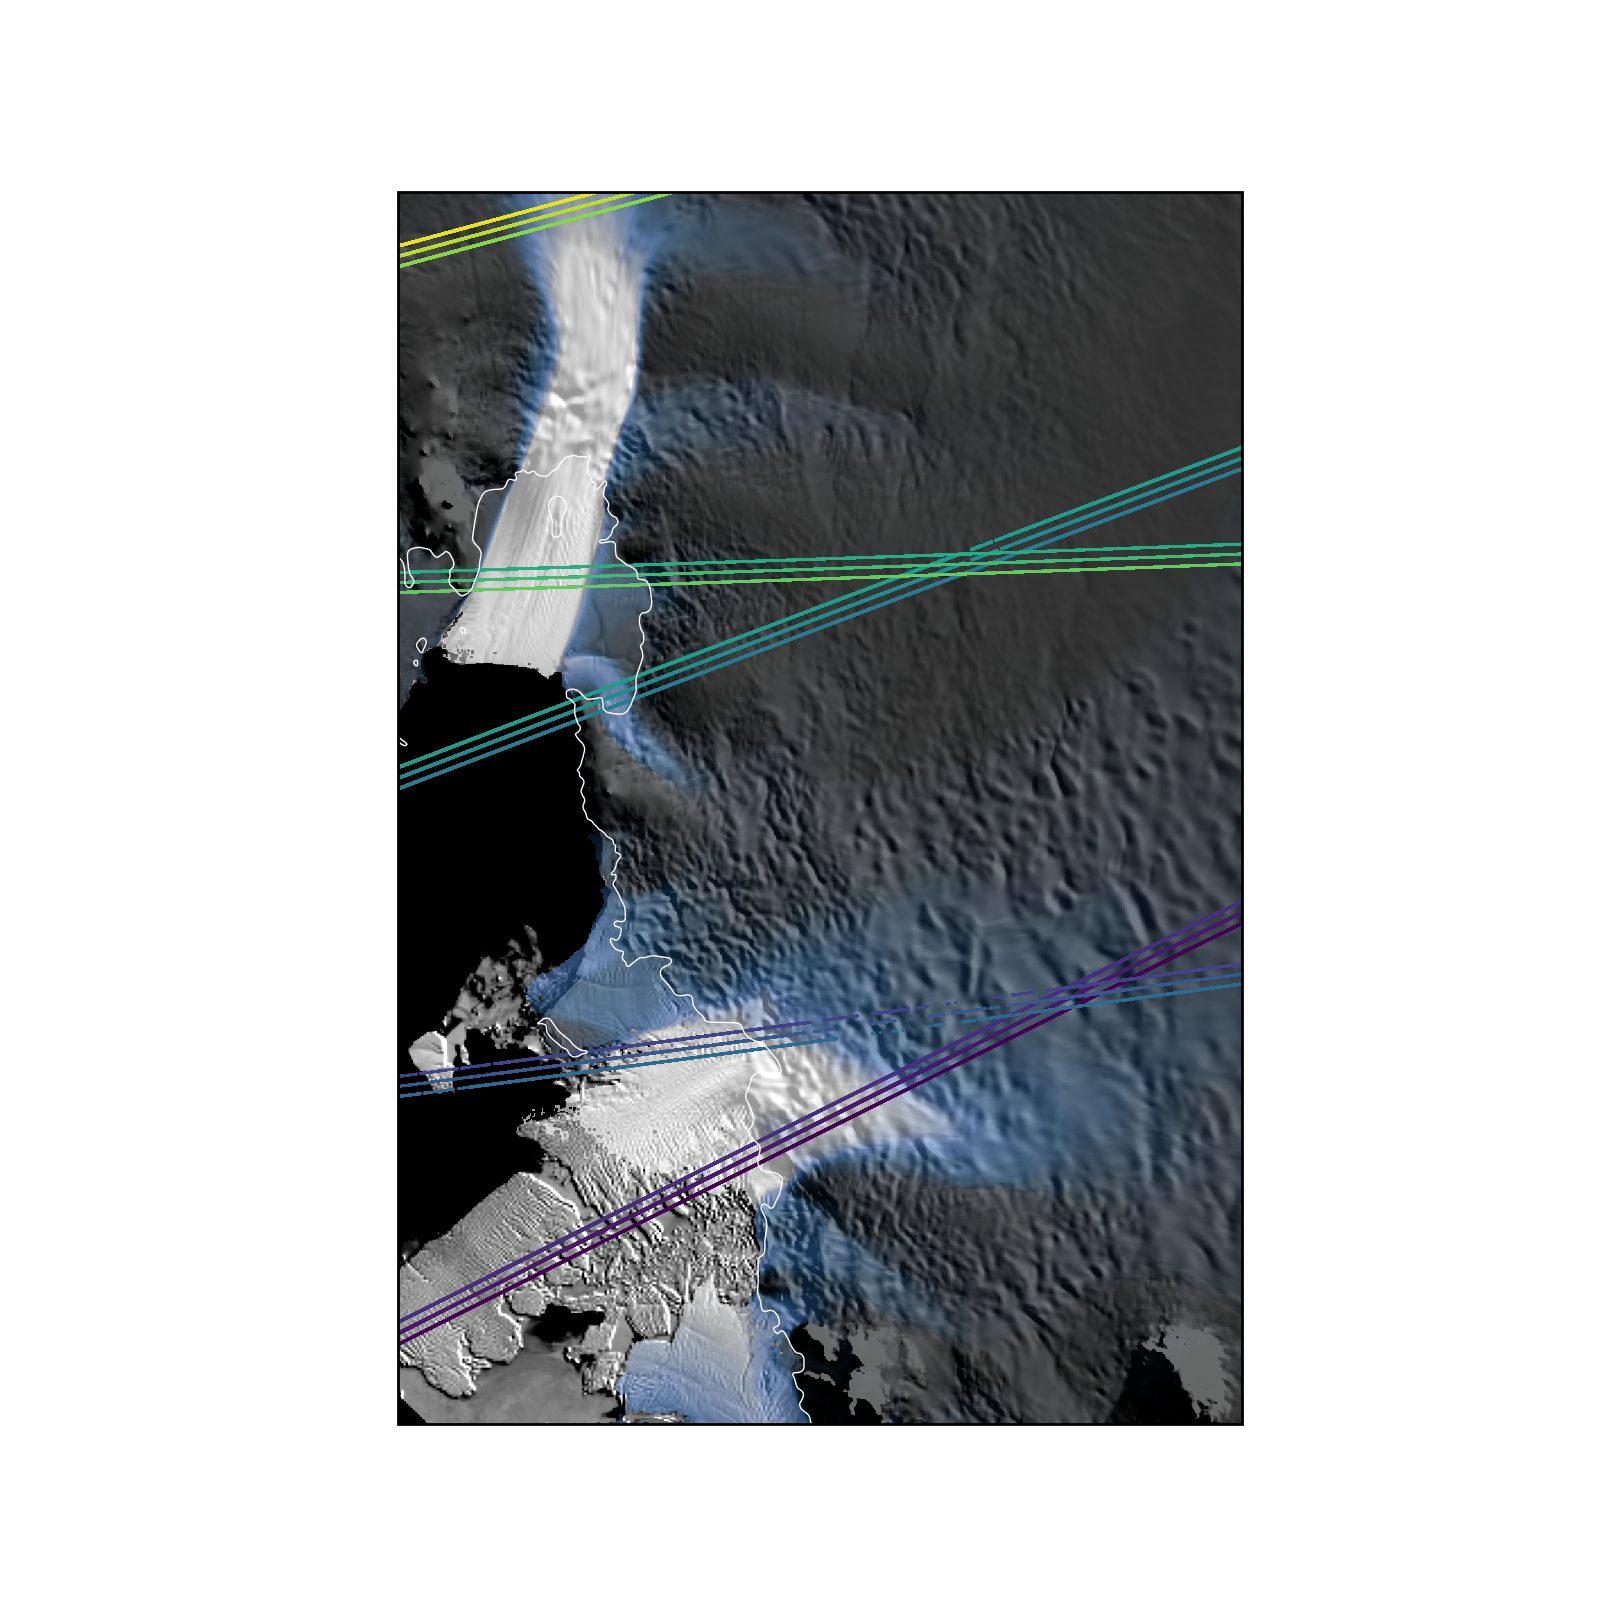

In [17]:
# Find best ATL06 tracks to use
# 127-131 crosses the crevasse on Bach
# 9/20 IS2 data crosses over W. Thwaites, 9/21 IS2 over E. Thwaites
vmin = 0
vmax = 200
is2_start = 31 #127
is2_end = 60 #131
ps71_projection = ccrs.Stereographic(
    central_latitude=-90, central_longitude=0, true_scale_latitude=-71
)
fig, ax = plt.subplots(subplot_kw={"projection": ps71_projection}, figsize=(16, 16))

ax.imshow(moa_dat, extent=ext, cmap="gray", vmin=15000, vmax=17000)
cb = ax.imshow(
    vel_mag_sliced,
    cmap=oslo,
    extent=[
        vel_mag_sliced["x"].min(),
        vel_mag_sliced["x"].max(),
        vel_mag_sliced["y"].min(),
        vel_mag_sliced["y"].max(),
    ],
    origin="upper",
    alpha=0.6,
    vmin=0,
    vmax=1600,
)

sf = shapefile.Reader(gl_path)
for i, shape in enumerate(sf.shapes(bbox=bbox)):
    if i > 5:
        points = shape.points
        # Only get points within bounding box
        line = LineString(points)
        plot_line(line, ax=ax, add_points=False, color="white", linewidth=1, zorder=2)

cmap = plt.get_cmap("viridis")

for i, data in enumerate(arr06[is2_start:is2_end]):
    print(data["name"])
    color = cmap(i / (is2_end - is2_start))
    ax.scatter(data["x"], data["y"], color=color, s=1, transform=ps71_projection)

ax.set_xlim(bbox[0], bbox[2])
ax.set_ylim(bbox[1], bbox[3])

In [14]:
# Function with help from ChatGPT
def prep_velocity_interpolators(vel):
    vx_interp = RegularGridInterpolator(
        (vel.y.values[::-1], vel.x.values),
        vel["VX"].values[::-1, :],
        bounds_error=False,
        fill_value=np.nan,
    )
    vy_interp = RegularGridInterpolator(
        (vel.y.values[::-1], vel.x.values),
        vel["VY"].values[::-1, :],
        bounds_error=False,
        fill_value=np.nan,
    )
    return vx_interp, vy_interp


# Advect
atl_06_indices = np.arange(is2_start, is2_end)
for index in atl_06_indices:
    start_x = arr06[index]["x"].copy()
    start_y = arr06[index]["y"].copy()
    start_time = arr06[index]["time"].copy()
    # Mask to bbox
    mask = (
        (start_x > bbox[0])
        & (start_x < bbox[2])
        & (start_y > bbox[1])
        & (start_y < bbox[3])
    )
    start_x[~mask] = np.nan
    start_time = [pyasl.decimalYearGregorianDate(t) for t in start_time]
    target_time = st_swot - datetime.timedelta(days=0)
    step_size = 1 / 366  # 1 day
    steps = [(target_time - t) for t in start_time]
    steps = [
        int(step.total_seconds() / (366 * 24 * 60 * 60) / step_size) for step in steps
    ]  # 366 as 2024 leap year

    step_size = np.sign(steps[0]) * step_size
    steps = np.abs(steps)

    # Prep velocity interpolator
    vx_interp, vy_interp = prep_velocity_interpolators(cropped_vel)

    # Assume points want the same number of steps to vectorize
    x = start_x.copy()
    y = start_y.copy()
    for i in range(steps[0]):
        vx = vx_interp((y, x))
        vy = vy_interp((y, x))
        x = x + vx * step_size
        y = y + vy * step_size
    arr06[index]["x_advected"] = x
    arr06[index]["y_advected"] = y

NameError: name 'is2_start' is not defined

In [ ]:
def plot_shapefile(
    records: list[shapefile._Record],
    shapes: list[shapefile.Shape],
    ax,
    colors: list[str],
    transform,
    fill: bool = False,
) -> None:
    """
    Plots the given records and shapes on axis ax.

    Parameters
    ----------
    records : list[shapefile._Record]
        Shapely record containing shape classification
    shapes : list[shapefile.Shape]
        Shapely shape points
    ax : cartopy.mpl.geoaxes.GeoAxes
        Axes to polot on
    colors : list[str]
       [Grounded ice color, Ice Shelf color]; Must be length 2
    """
    for record, shape in zip(records, shapes):
        classification = record[field_names.index("Id_text")]
        points = shape.points
        parts = list(shape.parts)
        parts.append(
            len(points)
        )  # Append the end index of the last part of the shapefile
        for i in range(len(parts) - 1):
            part = points[parts[i] : parts[i + 1]]
            if (
                classification == "Isolated island"
                or classification == "Ice rise or connected island"
                or classification == "Grounded ice or land"
            ):
                if fill:
                    ax.fill(*zip(*part), color=colors[0], zorder=2, transform=transform)
                else:
                    ax.plot(
                        *zip(*part),
                        color=colors[0],
                        linewidth=1.5,
                        zorder=2,
                        transform=transform,
                    )
            elif classification == "Ice shelf":
                if fill:
                    ax.fill(*zip(*part), color=colors[1], zorder=2, transform=transform)
                else:
                    ax.plot(
                        *zip(*part),
                        color=colors[1],
                        linewidth=1.5,
                        zorder=2,
                        transform=transform,
                    )
            else:
                print(f"Unknown classification: {classification}")

In [ ]:
import shapely

ice_shelf_polygons = []
grounded_polygons = []

sf = shapefile.Reader(gl_path)
fields = sf.fields[1:]  # Skip deletion flag
field_names = [field[0] for field in fields]

records = sf.records()
shapes = sf.shapes()

for record, shape in zip(records, shapes):
    classification = record[field_names.index("Id_text")]
    points = shape.points
    parts = list(shape.parts)
    parts.append(len(points))  # Append the end index of the last part
    for i in range(len(parts) - 1):
        part = points[parts[i] : parts[i + 1]]
        polygon = shapely.Polygon(part)
        if (
            classification == "Isolated island"
            or classification == "Ice rise or connected island"
            or classification == "Grounded ice or land"
        ):
            if polygon.is_valid:
                grounded_polygons.append(polygon)
        elif classification == "Ice shelf":
            if polygon.is_valid:
                ice_shelf_polygons.append(polygon)
        else:
            print(f"Unknown classification: {classification}")

# Filter records and shapes to bbox
filtered_records = []
filtered_shapes = []
for record, shape in zip(records, shapes):
    shape_bbox = shape.bbox
    # Checks if any part of the shape is within the bounding box
    if (
        shape_bbox[0] < bbox[2]
        and shape_bbox[2] > bbox[0]
        and shape_bbox[1] < bbox[3]
        and shape_bbox[3] > bbox[1]
    ):
        filtered_records.append(record)
        filtered_shapes.append(shape)

In [33]:
%%time
# Find tide corrections using CATS at times of interest

# Swot and ICESat-2 Times
print(f"SWOT time: {ds.time_granule_start}")
print(
    f"ICESat-2 time: {pyasl.decimalYearGregorianDate(arr06[atl_06_indices[3]]['time'][0])}"
)

swot_dt = datetime.datetime.strptime(ds.time_granule_start, "%Y-%m-%dT%H:%M:%S.%fZ")
tide_times = [
    swot_dt,
    pyasl.decimalYearGregorianDate(arr06[atl_06_indices[3]]["time"][0]),
]
sats = ["SWOT", "IS2"]
data["lon_advected"], data["lat_advected"] = transform.xy2ll(
    data["x_advected"], data["y_advected"]
)

for tide_time, satellite in zip(tide_times, sats):
    tides = Tides.Tide(tide_mod, tide_dir)
    tide_results = tides.tidal_elevation(
        data["lon_advected"],
        data["lat_advected"],
        [tide_time],
    ).data.T

    data[f"tide_{satellite}"] = tide_results

data["tide_IS2"] = data["tide_IS2"].astype("float32").squeeze()
data["tide_SWOT"] = data["tide_SWOT"].astype("float32").squeeze()

SWOT time: 2024-11-02T18:57:15.132331Z
ICESat-2 time: 2024-10-27 13:55:46.000791
CPU times: user 1min 18s, sys: 9.2 s, total: 1min 27s
Wall time: 1min 31s


In [40]:
# Make corrected height based on Susan Howard's doc
data["h_li_corrected"] = (
    data["h_li"]
    - data["geoid_h"]
    + data["geoid_free2mean"]
    - data["tide_earth"]
    + data["tide_earth_free2mean"]
    - data["tide_pole"]
    - data["tide_load"]
)

In [43]:
arr06[0]

{'lat': array([-72.07565403, -72.07706777, -72.07742316, ..., -79.00166976,
        -79.00202692, -79.0044692 ]),
 'lon': array([-103.82715676, -103.82779052, -103.82790092, ..., -108.35741815,
        -108.35763336, -108.36026017]),
 'h_li': array([nan, nan, nan, ..., nan, nan, nan], dtype=float32),
 't_dt': array([2.14966597e+08, 2.14966597e+08, 2.14966597e+08, ...,
        2.14966707e+08, 2.14966707e+08, 2.14966707e+08]),
 'q_flag': array([1, 1, 1, ..., 1, 1, 1], dtype=int8),
 'geoid_h': array([-25.893747, -25.892782, -25.89253 , ..., -32.994698, -32.9952  ,
        -32.998726], dtype=float32),
 'geoid_free2mean': array([-0.2196528 , -0.21965836, -0.21965976, ..., -0.24209426,
        -0.24209516, -0.24210133], dtype=float32),
 'tide_ocean': array([-0.47206897, -0.47213364, -0.47214955, ...,         nan,
                nan,         nan], dtype=float32),
 'dac': array([0.2394784 , 0.23946738, 0.23946455, ..., 0.06020872, 0.06020979,
        0.06021701], dtype=float32),
 'tide_earth'

In [44]:
data

{'lat': array([-79.00553803, -79.00536308, -79.00518815, ..., -72.47661976,
        -72.47644296, -72.47626614]),
 'lon': array([-104.95591417, -104.95609212, -104.9562705 , ..., -109.31805929,
        -109.3181378 , -109.31821573]),
 'h_li': array([1758.9934, 1758.8378, 1758.715 , ...,       nan,       nan,
              nan], dtype=float32),
 't_dt': array([2.15272547e+08, 2.15272547e+08, 2.15272547e+08, ...,
        2.15272652e+08, 2.15272652e+08, 2.15272652e+08]),
 'q_flag': array([0, 0, 0, ..., 1, 1, 1], dtype=int8),
 'geoid_h': array([-30.702148, -30.702152, -30.702156, ..., -30.081812, -30.081465,
        -30.081123], dtype=float32),
 'geoid_free2mean': array([-0.24210411, -0.24210377, -0.24210332, ..., -0.22121495,
        -0.22121425, -0.22121355], dtype=float32),
 'tide_ocean': array([       nan,        nan,        nan, ..., 0.15988854, 0.15987852,
        0.15986831], dtype=float32),
 'dac': array([0.19147022, 0.19147438, 0.19147979, ..., 0.54152966, 0.5415386 ,
        0.54

[31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54
 55 56 57 58 59]
<File-like object S3FileSystem, podaac-swot-ops-cumulus-protected/SWOT_L2_HR_Raster_2.0/SWOT_L2_HR_Raster_100m_UTM60W_N_x_x_x_023_323_138F_20241102T185715_20241102T185736_PIC2_01.nc>


KeyError: 'h_li_corrected'

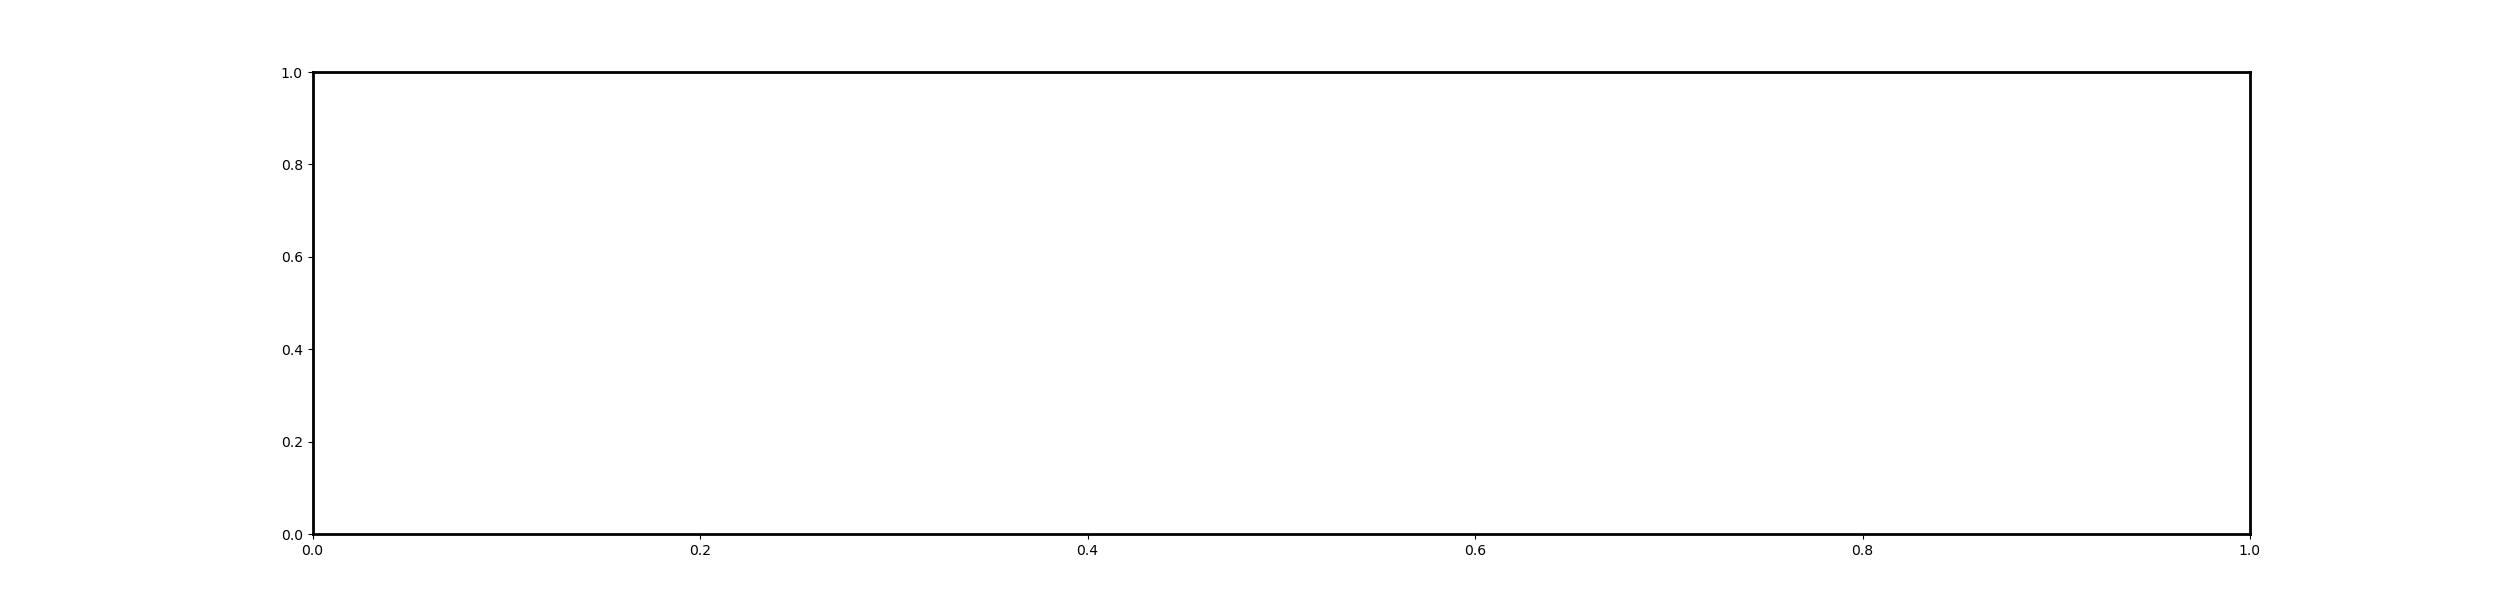

In [39]:
# Interpolate SWOT swath along icesat-2 track
to_plot = "wse"
print(atl_06_indices)
for i, idx in enumerate(atl_06_indices):
    data06 = arr06[idx]
    fig, ax = plt.subplots(figsize=(25, 6))

    overall_wse = np.zeros_like(data06["x_advected"])
    overall_wse[:] = np.nan
    overall_wse_sigma = np.zeros_like(data06["x_advected"])
    overall_wse_sigma[:] = np.nan
    for file in rasters[:1]:
        print(file)

        ds = xr.open_mfdataset(
            file, combine="nested", concat_dim="num_lines", decode_times=False
        )
        wse = ds[to_plot].isel(num_lines=0)
        wse_sigma = ds["wse_uncert"].isel(num_lines=0)
        utm = ccrs.UTM(zone=ds.utm_zone_num, southern_hemisphere=True)
        ps71_projection = ccrs.Stereographic(
            central_latitude=-90, central_longitude=0, true_scale_latitude=-71
        )
        # Convert icesat2 to utm
        x_utm = wse["x"].values
        y_utm = wse["y"].values
        advected_x_utm, advected_y_utm = transform.ps712utm(
            data06["x_advected"], data["y_advected"], utm.to_epsg()
        )

        advected_x_utm = xr.DataArray(advected_x_utm, dims=["points"])
        advected_y_utm = xr.DataArray(advected_y_utm, dims=["points"])

        x_utm = wse["x"].values
        y_utm = wse["y"].values

        interpolated_wse = wse.interp(
            x=advected_x_utm,
            y=advected_y_utm,
            method="linear",
            kwargs={"fill_value": np.nan},
        ).compute()
        interpolated_wse_sigma = wse_sigma.interp(
            x=advected_x_utm,
            y=advected_y_utm,
            method="linear",
            kwargs={"fill_value": np.nan},
        ).compute()

        # Put all non-nan values into overall_wse
        mask = np.isnan(overall_wse) & ~np.isnan(interpolated_wse)

        # Only update at those places
        overall_wse[mask] = interpolated_wse[mask]
        overall_wse_sigma[mask] = interpolated_wse_sigma[mask]

    lower = overall_wse - 2 * overall_wse_sigma
    upper = overall_wse + 2 * overall_wse_sigma
    ax.plot(
        data["x_advected"],
        data["h_li_corrected"] - data["tide_IS2"] / 100,
        color="#21314D",
        linewidth=2,
        label="ICESat-2",
    )
    ax.plot(
        data["x_advected"],
        overall_wse - data["tide_SWOT"] / 100,
        color="#D34B29",
        linewidth=2,
        label="SWOT",
    )
    ax.fill_between(
        data["x_advected"],
        lower - data["tide_SWOT"] / 100,
        upper - data["tide_SWOT"] / 100,
        color="#D34B29",
        alpha=0.3,
    )

    ax.set_xlabel("PS71 X [km]", fontsize=30)
    ax.set_ylabel("Elevation [m]", fontsize=30)
    KM_SCALE = 1e3
    ticks_x = ticker.FuncFormatter(lambda x, pos: "{0:g}".format(x / KM_SCALE))
    ax.xaxis.set_major_formatter(ticks_x)
    ax.tick_params(axis="both", which="major", labelsize=30, size=10)
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.set_xlim(np.nanmin(data["x_advected"]), np.nanmax(data["x_advected"]))
    # Find firs and last non nan index of interpolated wse
    first_non_nan = np.where(~np.isnan(overall_wse))[0][0]
    last_non_nan = np.where(~np.isnan(overall_wse))[0][-1]
    print(first_non_nan, last_non_nan)
    print(data["x_advected"][first_non_nan], data["x_advected"][last_non_nan])
    ax.set_xlim(data["x_advected"][first_non_nan], data["x_advected"][last_non_nan])
    ax.set_xlim(data["x_advected"][first_non_nan], -1860000)  # For top cog plot
    ax.set_ylim(-10, 35)

    ax.legend(fontsize=30, loc="lower left")
    # Remove legend border
    leg = ax.get_legend()
    for line in leg.get_lines():
        line.set_linewidth(3)
    # Set legend border color and width
    leg.get_frame().set_edgecolor("white")
    leg.get_frame().set_linewidth(1)

    # Flip x axis
    # ax.set_xlim(ax.get_xlim()[::-1])

In [ ]:
# Plot Figure 2
to_plot = "wse"
label = "Elevation [m]"
vmin = 0
vmax = 200

ps71_projection = ccrs.Stereographic(
    central_latitude=-90, central_longitude=0, true_scale_latitude=-71
)
fig = plt.figure(figsize=(16, 20))

gs = gridspec.GridSpec(2, 1, height_ratios=[4, 1])
ax = fig.add_subplot(gs[0], projection=ps71_projection)

ax.imshow(moa_dat, extent=ext, cmap="gray", vmin=15000, vmax=17000)
cb = ax.imshow(
    vel_mag_sliced,
    cmap=oslo,
    extent=[
        vel_mag_sliced["x"].min(),
        vel_mag_sliced["x"].max(),
        vel_mag_sliced["y"].min(),
        vel_mag_sliced["y"].max(),
    ],
    origin="upper",
    alpha=0.6,
    vmin=0,
    vmax=1600,
)
plot_shapefile(records, shapes, ax, ["white", "none"], ps71_projection, fill=False)
print("PLOTTING RASTERS")
for file in rasters[:]:
    print(file)

    ds = xr.open_mfdataset(
        file, combine="nested", concat_dim="num_lines", decode_times=False
    )
    wse = ds[to_plot].isel(num_lines=0)
    if to_plot == "wse":
        xover_corr = ds["height_cor_xover"].isel(num_lines=0)
        wse = wse + xover_corr
    utm = ccrs.UTM(zone=ds.utm_zone_num, southern_hemisphere=True)
    x = wse["x"].values
    y = wse["y"].values

    X, Y = np.meshgrid(x, y)
    mesh = ax.pcolormesh(
        X,
        Y,
        wse.values,
        transform=utm,
        cmap="viridis",
        shading="auto",
        vmin=vmin,
        vmax=vmax,
    )

print("PLOTTING ICESAT-2")
for i, idx in enumerate(atl_06_indices[:4]):
    data = arr06[idx]
    ax.scatter(
        data["x_advected"],
        data["y_advected"],
        color="white",
        s=5,
        transform=ps71_projection,
    )

ax.set_xlim(bbox[0] + 1000, bbox[2] - 1000)
ax.set_ylim(bbox[1] + 1000, bbox[3] - 1000)

print("COLORBARS")
k_cbar_anchor = (0.999, 0.87)
cbbox = inset_axes(
    ax,
    width=5.5,
    height=1.7,
    bbox_to_anchor=k_cbar_anchor,
    bbox_transform=ax.transAxes,
    loc="upper right",
)
[cbbox.spines[k].set_visible(False) for k in cbbox.spines]
cbbox.tick_params(
    axis="both",
    left=False,
    top=False,
    right=False,
    bottom=False,
    labelleft=False,
    labeltop=False,
    labelright=False,
    labelbottom=False,
)
cbbox.set_facecolor([0, 0, 0, 0.7])

cbaxes = inset_axes(cbbox, "92%", "20%", loc="center")
cbar = fig.colorbar(
    mesh, cax=cbaxes, orientation="horizontal", extend="max"
)  # make colorbar
cbar.outline.set_edgecolor("white")
cbar.outline.set_linewidth(1)
cbar.ax.tick_params(labelsize=30, color="white", labelcolor="white")
cbar.set_label(label, fontsize=34, color="white")
cbar.ax.xaxis.set_label_position("top")

cbar.ax.minorticks_on()

cbar.ax.tick_params(which="minor", length=4, color="white")


v_cbar_anchor = (0.999, 0.999)
cbbox = inset_axes(
    ax,
    width=5.5,
    height=1.7,
    bbox_to_anchor=v_cbar_anchor,
    bbox_transform=ax.transAxes,
    loc="upper right",
)
[cbbox.spines[k].set_visible(False) for k in cbbox.spines]
cbbox.tick_params(
    axis="both",
    left=False,
    top=False,
    right=False,
    bottom=False,
    labelleft=False,
    labeltop=False,
    labelright=False,
    labelbottom=False,
)
cbbox.set_facecolor([0, 0, 0, 0.7])

cbaxes = inset_axes(cbbox, "92%", "20%", loc="center")
cbar = fig.colorbar(cb, cax=cbaxes, orientation="horizontal")  # make colorbar
cbar.outline.set_edgecolor("white")
cbar.outline.set_linewidth(1)
cbar.ax.tick_params(labelsize=30, color="white", labelcolor="white")
cbar.set_label("Ice Velocity [m/a]", fontsize=34, color="white")
cbar.ax.xaxis.set_label_position("top")

cbar.ax.minorticks_on()

cbar.ax.tick_params(which="minor", length=4, color="white")

print("SCALEBAR AND INSET")
scalebar = AnchoredSizeBar(
    ax.transData,
    20000,
    "20 km",
    "lower right",
    pad=0.1,
    sep=1,
    color="white",
    frameon=False,
    size_vertical=2000,
    fontproperties=mpl.font_manager.FontProperties(size=30, weight="bold"),
    label_top=False,
)

# Add inset map using moa grounding lines
inset = fig.add_axes(
    [0.15, 0.73, 0.3, 0.3], projection=ps71_projection
)  # [left, bottom, width, height]
inset.patch.set_facecolor("none")
for spine in inset.spines.values():
    spine.set_visible(False)
inset.set_xticks([])
inset.set_yticks([])

plot_shapefile(
    records, shapes, inset, ["lightgray", "white"], ps71_projection, fill=True
)
rect = plt.Rectangle(
    (
        bbox[0],
        bbox[1],
    ),
    bbox[2] - bbox[0],
    bbox[3] - bbox[1],
    zorder=3,
    linewidth=1,
    edgecolor="red",
    facecolor="none",
)
inset.add_patch(rect)


ax.add_artist(scalebar)
scalebar.set_bbox_to_anchor((0.99, 0.7), transform=ax.transAxes)


plt.draw()

data = arr06[atl_06_indices[3]]
# Mask to values shown in chart: xadvected -2265000 to -2265000+35000
x_mask = (data["x_advected"] > data["x_advected"][first_non_nan]) & (
    data["x_advected"] < -1860000
)

x_plotting = data["x_advected"][x_mask]
y_plotting = data["y_advected"][x_mask]
ax.scatter(x_plotting, y_plotting, color="#D34B29", s=5, transform=ps71_projection)

ax2 = fig.add_subplot(gs[1])
ax2.plot(
    data["x_advected"],
    data["h_li_corrected"] - data["tide_IS2"] / 100,
    color="#21314D",
    linewidth=2,
    label="ICESat-2",
)
ax2.plot(
    data["x_advected"],
    overall_wse - data["tide_SWOT"] / 100,
    color="#D34B29",
    linewidth=2,
    label="SWOT",
)
ax2.fill_between(
    data["x_advected"],
    lower - data["tide_SWOT"] / 100,
    upper - data["tide_SWOT"] / 100,
    color="#D34B29",
    alpha=0.3,
)


ax2.set_xlabel("PS71 X [km]", fontsize=30)
ax2.set_ylabel("Elevation [m]", fontsize=30)
KM_SCALE = 1e3
ticks_x = ticker.FuncFormatter(lambda x, pos: "{0:g}".format(x / KM_SCALE))
ax2.xaxis.set_major_formatter(ticks_x)
ax2.tick_params(axis="both", which="major", labelsize=30, size=10)
ax2.spines["top"].set_visible(False)
ax2.spines["right"].set_visible(False)
ax2.set_xlim(np.nanmin(data["x_advected"]), np.nanmax(data["x_advected"]))
# Find firs and last non nan index of interpolated wse
first_non_nan = np.where(~np.isnan(overall_wse))[0][0]
last_non_nan = np.where(~np.isnan(overall_wse))[0][-1]
print(first_non_nan, last_non_nan)
print(data["x_advected"][first_non_nan], data["x_advected"][last_non_nan])
ax2.set_xlim(data["x_advected"][first_non_nan], data["x_advected"][last_non_nan])
ax2.set_xlim(data["x_advected"][first_non_nan], -1860000)  # For top cog plot
ax2.set_ylim(10, 35)

handles = [
    Line2D([0], [0], color="#21314D", linewidth=2, label="ICESat-2"),
    Line2D([0], [0], color="#D34B29", linewidth=2, label="SWOT"),
    Patch(facecolor="#D34B29", alpha=0.3, label="SWOT Uncertainty"),
]

ax2.legend(
    fontsize=30,
    loc="lower left",
    handles=handles[:1] + [handles[1]],
)
# Remove legend border
leg = ax2.get_legend()
for line in leg.get_lines():
    line.set_linewidth(3)
# Set legend border color and width
leg.get_frame().set_edgecolor("white")
leg.get_frame().set_linewidth(1)

ax.text(-0.17, 0.95, "A.", transform=ax.transAxes, fontsize=40, color="black")

ax2.text(-0.17, 0.95, "B.", transform=ax2.transAxes, fontsize=40, color="black")

ax.text(
    0.01,
    0.01,
    "SWOT: 2025-01-27\nICESat-2: 2024-12-13",
    transform=ax.transAxes,
    fontsize=30,
    color="white",
)
fig.tight_layout()
plt.savefig("../figures/Figure2_tms.png", dpi=500, bbox_inches="tight")